Learning `scan` - it's in the LGT time series example and it looks really powerful.

In the context of time series models, `scan` is helpful because it allows us to iterate over sequences (without a cumbersome `for` loop) while maintaining state across each iteration. 

Here are components of the `scan` function:

1. **Input Function**: `scan` takes an input function $f$ that defines the computation you want to perform at each step. This function typically takes two arguments:
   1. `carry`: A tuple that represents the state or context at the current time step. This is passed from one iteration to the next, allowing you to maintain and update state across time steps.
   2. `x`: The current element from the input sequence or array.
2. **Initial State (init)**: You also provide an initial state or `carry`` value. This is the state that the computation starts with at the first time step.
3. **Sequencing**: The `scan` function applies the provided function to each element in the input sequence in order, passing the current carry value and the current element x to the function. It iterates over the entire sequence.
4. **Aggregation**: The output of the function at each time step can be used to produce an output sequence, and the final `carry` value at the last time step can represent the final state. The resulting sequences or values can be collected and returned.

 

The Input function also returns two items:

1. The carried over value(s), aka the latest state
2. An array, where each element is something returned from the Input Function `f` as it passes each element in `xs`



## Trivial Example

In [3]:
import jax.numpy as jnp
from numpyro.contrib.control_flow import scan
import numpyro.distributions as dist
from jax import random

## Trival Example - CumSum

* [From The Differential Programming Tutorial - Loopy Carry, by Eric Ma](https://ericmjl.github.io/dl-workshop/02-jax-idioms/02-loopy-carry.html)



In [4]:
# import jax.numpy as np

a = jnp.array([1, 2, 3, 5, 7, 11, 13, 17])

result = []
res = 0
for el in a:
    res += el
    result.append(res)
jnp.array(result)

Array([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

This is identical to the cumulative sum:

In [5]:
jnp.cumsum(a)

Array([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

Now, instead of a for loop, we rewrite it using lax.scan:

In [6]:
from jax import lax

def cumsum(res, el):
    """
    Parameters
    ----------
    res : tuple
        A tuple - the result from the previous loop, aka the 'carry'
    el
        The current array element, also `x`
    """
    res += el
    return res, res # ('carryover', 'accumulated')

result_init = 0
final, result = lax.scan(cumsum, result_init, a)
print(final)
print(result)

59
[ 1  3  6 11 18 29 42 59]


## Trivial Example 2: A little more of the carry function



In [7]:
# Define a function to apply at each time step
def interest_growth(value, x):
    value = value * 1.04
    return 5.0, value # ('carried over value', 'accumulated array')

# Define the initial state and input sequence
init_state = 100.0
T = jnp.array([1, 2, 3, 4, 5])

# Apply the scan function
# scan(f, init, xs, length=None, reverse=False, history=1)
final_state, results = scan(f=interest_growth, init=init_state, xs=T)

print(final_state)
print(results)

5.0
[104.    5.2   5.2   5.2   5.2]


## AR(2) Example

* [Example: AR2 process (numpyro docus)](https://num.pyro.ai/en/stable/examples/ar2.html#sphx-glr-download-examples-ar2-py)

Below I'll follow and document the AR2 example from the numpyro docs.

Given a univariate sequence of data:

$$
y_0, y_1, \dots, y_T
$$

We seek parameters $c$, $\alpha_1$, and $\alpha_2$ such that for each $t$ between $2$ and $T$, we have:

$$
y_t = c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2} + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2)
$$


We can restate this as:

$$
\begin{aligned}
y_t &\sim \mathcal{N}(\mu_t, \sigma)\\
\mu_t &= c + \alpha_1 y_{t-1} + \alpha_2 y_{t-2}\\
c &\sim \mathcal{N}(0,1)\\
\alpha_1 &\sim \mathcal{N}(0,1)\\
\alpha_2 &\sim \mathcal{N}(0,1)\\
\sigma &\sim \text{HalfNormal}(1)\\
\end{aligned}
$$

In [21]:
import numpyro 
from numpyro.infer import MCMC, NUTS, Predictive
import matplotlib.pyplot as plt
import arviz as az

def ar2_scan(y):
    """
    Bayesian autoregressive (AR) model of order 2
    """
    alpha_1 = numpyro.sample("alpha_1", dist.Normal(0, 1))  # lag 1 AR coef
    alpha_2 = numpyro.sample("alpha_2", dist.Normal(0, 1))  # lag 2 AR coef
    const = numpyro.sample("const", dist.Normal(0, 1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(1))

    def transition(carry, _):
        y_prev, y_prev_prev = carry
        m_t = const + alpha_1 * y_prev + alpha_2 * y_prev_prev
        y_t = numpyro.sample("y", dist.Normal(m_t, sigma))
        carry = (y_t, y_prev)
        return carry, None

    timesteps = jnp.arange(y.shape[0] - 2)  # input into xs param in scan()
    init = (y[1], y[0])

    with numpyro.handlers.condition(data={"y": y[2:]}):
        scan(f=transition, init=init, xs=timesteps)
    
    # Alternative using a `for` loop:
    
    # y_prev = y[1]
    # y_prev_prev = y[0]

    # for i in range(2, len(y)):
    #     m_t = const + alpha_1 * y_prev + alpha_2 * y_prev_prev
    #     y_t = numpyro.sample("y_{}".format(i), dist.Normal(m_t, sigma), obs=y[i])
    #     y_prev_prev = y_prev
    #     y_prev = y_t    


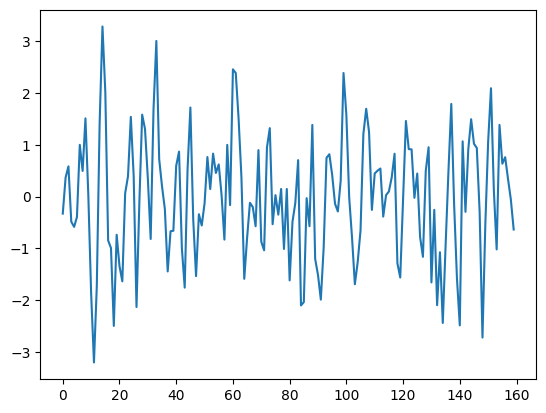

In [22]:
# constants
num_data = 160
rng_key = random.PRNGKey(42)
# Sim Data
from statsmodels.tsa.arima_process import ArmaProcess

t = jnp.arange(0, num_data)

# Generate an AR(2) model with coef 1.3, 0.7 and a constant
ar_coef = jnp.array([1, -0.5, 0.4])
ma_coef = jnp.array([1])
arproc = ArmaProcess(ar_coef, ma_coef)

y = arproc.generate_sample(num_data)
y = jnp.array(y)

# look at the data real quick:
plt.plot(t, y)

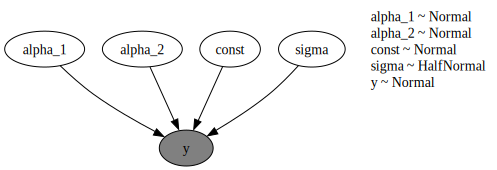

In [23]:
# Render the model so far
numpyro.render_model(ar2_scan, model_args=(y,), render_distributions=True)

In [24]:
# Inference
sampler = NUTS(ar2_scan)
mcmc = MCMC(sampler, num_warmup=1000, num_samples=1000, num_chains=1)
mcmc.run(rng_key, y=y)
mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1436.65it/s, 7 steps of size 6.55e-01. acc. prob=0.92]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   alpha_1      0.50      0.08      0.50      0.38      0.63    829.99      1.00
   alpha_2     -0.30      0.08     -0.30     -0.42     -0.16    893.14      1.00
     const     -0.02      0.08     -0.02     -0.16      0.12   1071.87      1.00
     sigma      1.06      0.06      1.06      0.96      1.17   1070.80      1.00

Number of divergences: 0


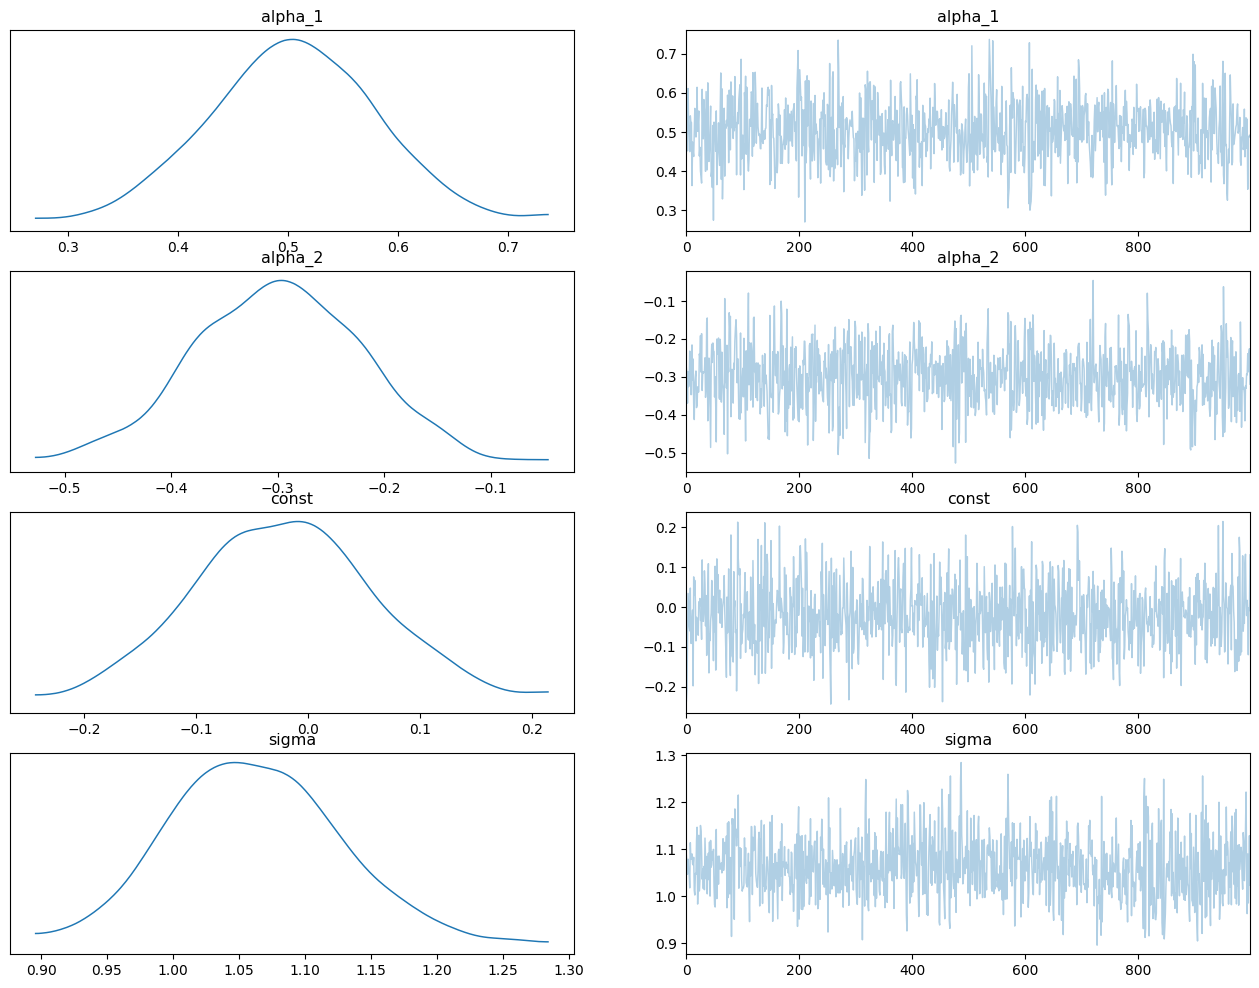

In [25]:
# Get data out as an xarray using arviz .from_numpyro() method
data = az.from_numpyro(mcmc)
# useful plot
az.plot_trace(data, compact=True, figsize=(16,12));

## AR(2) Statsmodels 


In [31]:
from statsmodels.tsa.ar_model import AutoReg

In [32]:
import numpy as np
mod = AutoReg(np.array(y), 2, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  160
Model:                     AutoReg(2)   Log Likelihood                -231.907
Method:               Conditional MLE   S.D. of innovations              1.050
Date:                Fri, 20 Oct 2023   AIC                            471.813
Time:                        14:28:42   BIC                            484.064
Sample:                             2   HQIC                           476.788
                                  160                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0199      0.084     -0.238      0.812      -0.184       0.144
y.L1           0.5098      0.076      6.725      0.000       0.361       0.658
y.L2          -0.3040      0.076     -4.011      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


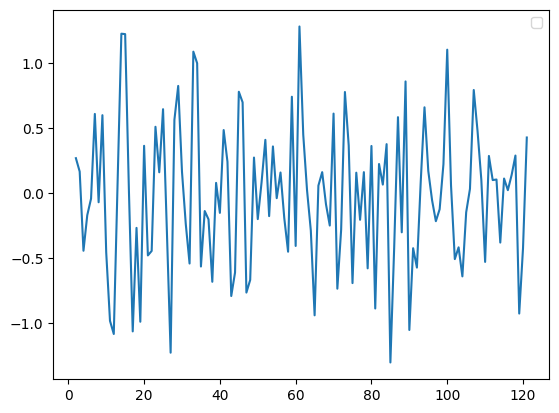

In [33]:
fig = res.plot_predict(0, 121)

## Local Level model

Essentially a random walk, or a regression model in which the intercept changes over time

$$
\begin{aligned}
y_t &= \mu_t + \epsilon_t, & \epsilon_t \sim N(0, \sigma_\epsilon^2)\\ 
\mu_{t+1} &= \mu_t + \xi_t, & \xi_t \sim N(0, \sigma_\xi^2)
\end{aligned}
$$

In [100]:
def local_level(y):
    T = len(y)

    # State space model parameters
    sigma_level = numpyro.sample("sigma_level", dist.HalfCauchy(1.0))
    sigma_obs = numpyro.sample("sigma_obs", dist.HalfCauchy(1.0))
    # level_0 = numpyro.sample("level_0", dist.Normal(y[0], 1.0))
    level_0 = y[0]

    def transition_fn(carry, t):
        level_t = carry
        # State Transition
        level_t = numpyro.sample(f"level", dist.Normal(level_t, sigma_level))
        # Observation equation
        y_t = numpyro.sample("y", dist.Normal(level_t, sigma_obs))
        
        return level_t, None

    N = y.shape[0]
    with numpyro.handlers.condition(data={"y": y[1:]}):
        _, ys = scan(
            transition_fn, init=level_0, xs=jnp.arange(1, N)
        )

Here we use the `condition` handler so that we only `scan` over all the values of `y` except for the first one, because we're using 

## render model

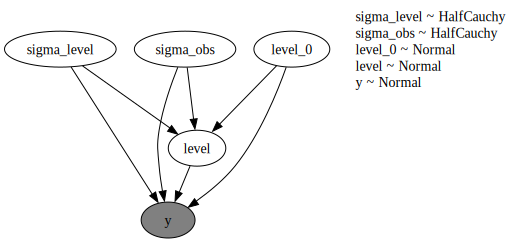

In [101]:
numpyro.render_model(local_level, model_args=(y,), render_distributions=True)

In [102]:
# sim data with numpy
np.random.seed(69)

T = 100
current_level = 0
result = []
for t in range(T):
    current_level += np.random.normal()
    result.append(current_level)

In [103]:
# sim data with jax

rng_key_ = random.PRNGKey(0)

# make an array of errors, and then we'll iterate over them
errors = dist.Normal().sample(rng_key_, (T,))

def simulate_local_level(current_level, x):
    current_level = current_level + x
    return current_level, current_level

final_state, y = scan(simulate_local_level, init=0, xs=errors)

In [104]:
## Prior Predictive
num_samples = 50
prior_predictive = Predictive(local_level, num_samples=num_samples)
prior_predictions = prior_predictive(rng_key, y)['y']

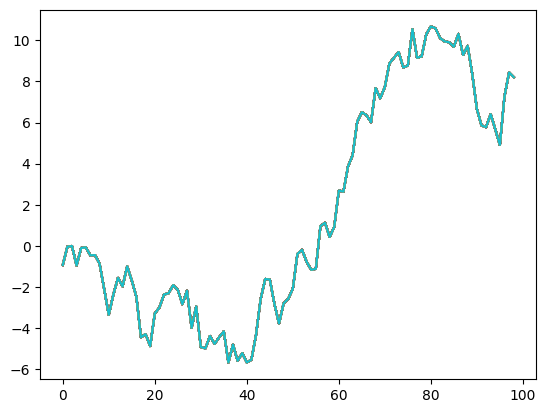

In [105]:
x = range(T-1)
for i in range(num_samples):
    plt.plot(x, prior_predictions[i])

In [106]:
# Inference
kernel = NUTS(local_level)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000)
mcmc.run(rng_key, y)

mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1285.24it/s, 3 steps of size 1.07e-01. acc. prob=0.64] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     level[0]     -0.93      0.11     -0.93     -1.07     -0.76   1543.69      1.00
     level[1]     -0.05      0.10     -0.04     -0.21      0.10    804.70      1.00
     level[2]     -0.02      0.10     -0.01     -0.17      0.10    886.85      1.01
     level[3]     -0.93      0.11     -0.95     -1.06     -0.76     81.11      1.03
     level[4]     -0.11      0.10     -0.11     -0.26      0.03   1369.79      1.00
     level[5]     -0.08      0.10     -0.07     -0.22      0.08    736.37      1.00
     level[6]     -0.46      0.10     -0.46     -0.59     -0.30   1459.89      1.00
     level[7]     -0.45      0.10     -0.45     -0.63     -0.30   1266.59      1.00
     level[8]     -0.88      0.10     -0.87     -1.02     -0.71    958.89      1.00
     level[9]     -2.10      0.09     -2.10     -2.24     -1.96   2609.22      1.00
    level[10]     -3.33      0.12     -3.35     -3.48     -3.19    134.62  

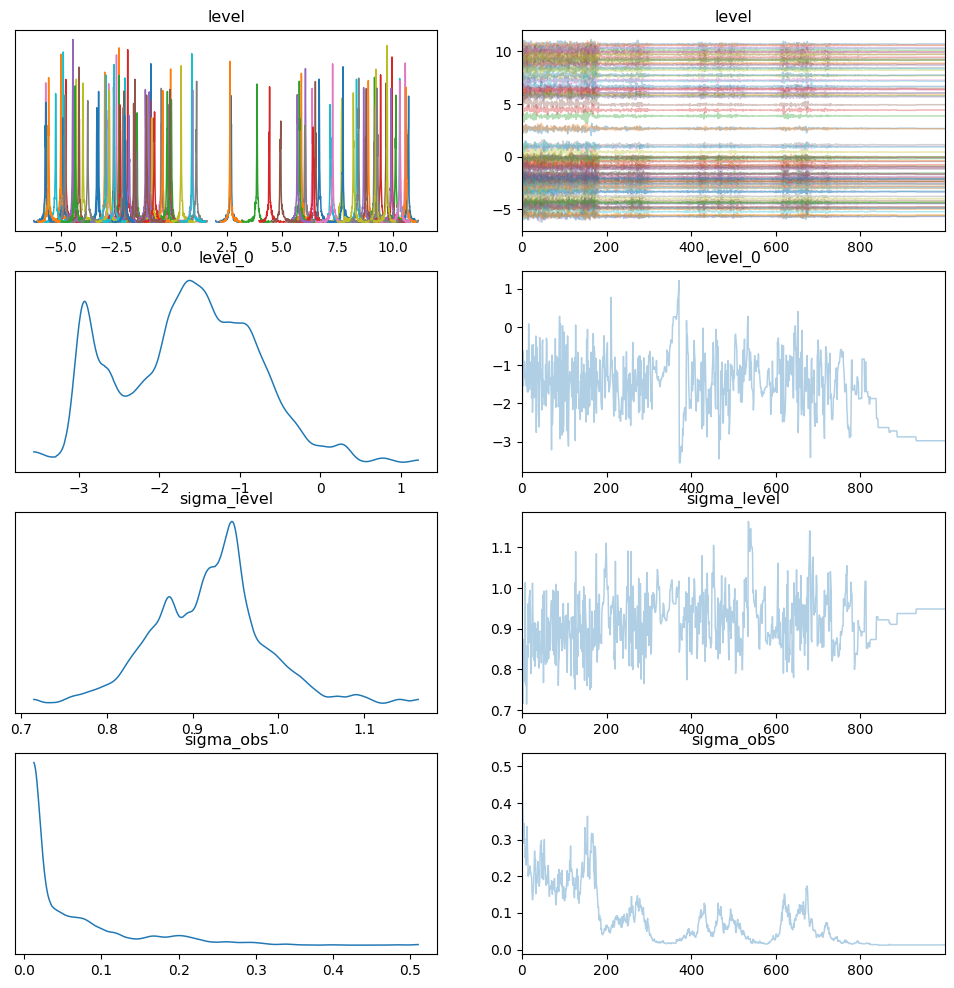

In [107]:
# useful plot
az.plot_trace(mcmc, compact=True, figsize=(12,12));

In [108]:
# Get posterior samples
samples = mcmc.get_samples()

# Extract posterior means of parameters and states
posterior_mean_level = jnp.mean(samples["level"], axis=0)
posterior_mean_sigma_level = jnp.mean(samples["sigma_level"])

print("Posterior Mean Level:", posterior_mean_level)
print("Posterior Mean Sigma Level:", posterior_mean_sigma_level)

Posterior Mean Level: [-0.9284372  -0.05156077 -0.01736136 -0.9291194  -0.11308829 -0.0801532
 -0.4556807  -0.45451024 -0.87702525 -2.1038957  -3.3310077  -2.371191
 -1.5746269  -1.9557511  -1.0206591  -1.6952916  -2.496206   -4.4236608
 -4.3053184  -4.8514037  -3.3066423  -3.0017405  -2.3734157  -2.303111
 -1.9241118  -2.1455464  -2.8228664  -2.2147405  -3.9576976  -2.9883237
 -4.898793   -4.983249   -4.393239   -4.7641306  -4.4528723  -4.1913733
 -5.648124   -4.818588   -5.580638   -5.228839   -5.665227   -5.5285273
 -4.333029   -2.6141846  -1.629552   -1.6580168  -2.8197734  -3.7512467
 -2.8112476  -2.5776913  -2.0746324  -0.41522726 -0.20813923 -0.7726501
 -1.1623902  -1.0896243   0.9380727   1.111054    0.44541493  0.93385816
  2.668141    2.6560442   3.854796    4.4260907   6.0264726   6.493685
  6.3569093   6.045655    7.6531653   7.189751    7.743284    8.874534
  9.157191    9.4219      8.693429    8.797192   10.507107    9.175288
  9.231572   10.291898   10.674247   10.580175

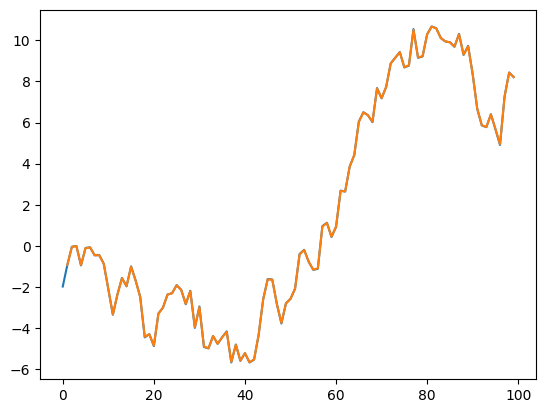

In [109]:
plt.plot(np.arange(0,T), y)
plt.plot(np.arange(1,T), posterior_mean_level)

## Local Level Nile Model

In [65]:
import statsmodels.api as sm
import pandas as pd

# This dataset is available in Statsmodels
nile = sm.datasets.nile.load_pandas().data['volume']
nile.index = pd.date_range('1871', '1970', freq='AS')

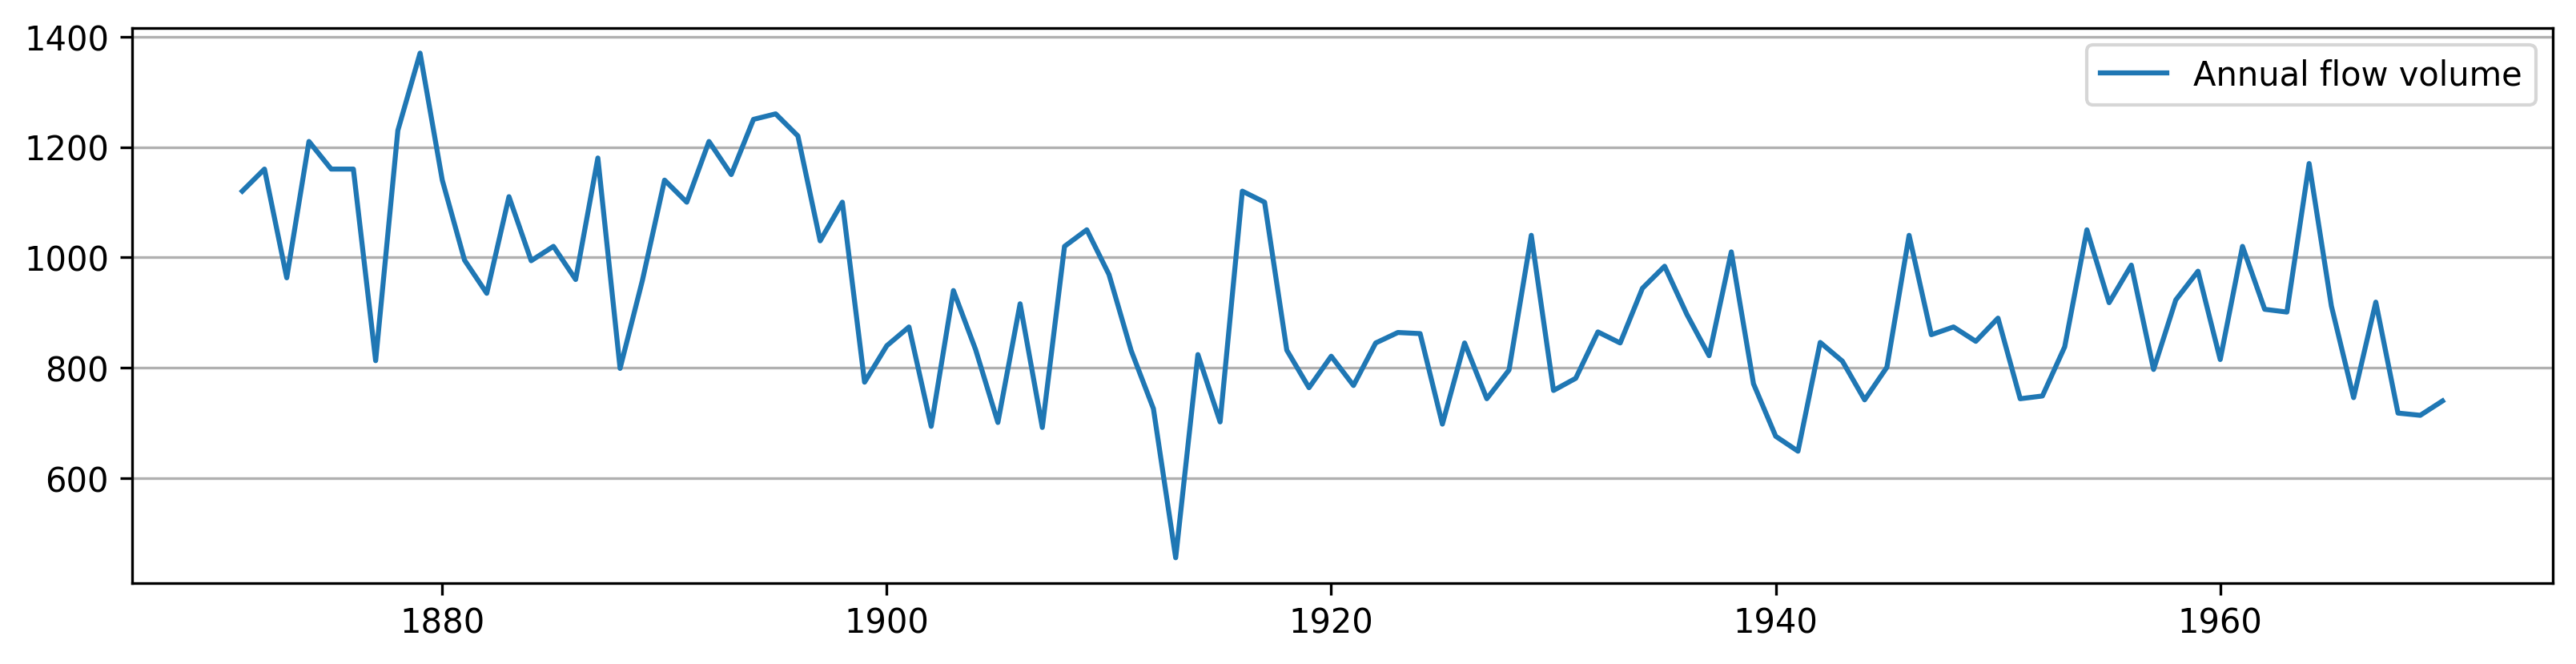

In [66]:
# Plot the series to see what it looks like
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ax.plot(nile.index, nile, label='Annual flow volume')
ax.legend()
ax.yaxis.grid()

In [72]:
jnp.array(nile)

Array([1120., 1160.,  963., 1210., 1160., 1160.,  813., 1230., 1370.,
       1140.,  995.,  935., 1110.,  994., 1020.,  960., 1180.,  799.,
        958., 1140., 1100., 1210., 1150., 1250., 1260., 1220., 1030.,
       1100.,  774.,  840.,  874.,  694.,  940.,  833.,  701.,  916.,
        692., 1020., 1050.,  969.,  831.,  726.,  456.,  824.,  702.,
       1120., 1100.,  832.,  764.,  821.,  768.,  845.,  864.,  862.,
        698.,  845.,  744.,  796., 1040.,  759.,  781.,  865.,  845.,
        944.,  984.,  897.,  822., 1010.,  771.,  676.,  649.,  846.,
        812.,  742.,  801., 1040.,  860.,  874.,  848.,  890.,  744.,
        749.,  838., 1050.,  918.,  986.,  797.,  923.,  975.,  815.,
       1020.,  906.,  901., 1170.,  912.,  746.,  919.,  718.,  714.,
        740.], dtype=float32)

In [74]:
# Inference
kernel = NUTS(local_level)
mcmc = MCMC(kernel, num_samples=1000, num_warmup=1000)
mcmc.run(rng_key, jnp.array(nile))

mcmc.print_summary()

sample: 100%|██████████| 2000/2000 [00:01<00:00, 1199.25it/s, 63 steps of size 1.50e-01. acc. prob=0.84]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
     level[0]   1119.59     28.93   1119.29   1073.38   1166.53    836.76      1.00
     level[1]   1116.28     37.16   1115.93   1061.59   1181.13    831.54      1.00
     level[2]   1108.96     40.07   1110.61   1042.38   1170.76    767.19      1.00
     level[3]   1114.30     42.52   1112.37   1039.15   1177.52    764.27      1.00
     level[4]   1111.90     44.40   1110.09   1045.10   1190.49    610.94      1.00
     level[5]   1104.00     42.62   1104.81   1029.66   1167.99    749.06      1.00
     level[6]   1093.20     43.29   1093.75   1024.96   1166.80    472.49      1.00
     level[7]   1108.15     43.55   1106.70   1042.02   1182.56    391.09      1.00
     level[8]   1111.99     46.58   1108.10   1046.96   1195.39    173.19      1.00
     level[9]   1094.24     42.32   1091.50   1029.07   1163.43    716.80      1.00
    level[10]   1073.66     42.88   1075.37   1003.93   1146.23    667.45  

In [75]:
# Get posterior samples
samples = mcmc.get_samples()

# Extract posterior means of parameters and states
posterior_mean_level = jnp.mean(samples["level"], axis=0)
posterior_mean_sigma_level = jnp.mean(samples["sigma_level"])

print("Posterior Mean Level:", posterior_mean_level)
print("Posterior Mean Sigma Level:", posterior_mean_sigma_level)

Posterior Mean Level: [1119.5916  1116.2802  1108.958   1114.3022  1111.8977  1103.9993
 1093.2021  1108.1542  1111.989   1094.2397  1073.6561  1062.0145
 1059.8993  1052.3895  1045.6893  1042.1848  1045.5146  1035.4557
 1045.144   1061.6041  1072.072   1083.0795  1086.7546  1089.6833
 1080.0898  1058.3483  1025.3002   993.6833   953.6751   927.6283
  907.7023   888.18726  884.9905   873.9684   863.988    867.78
  864.97736  879.27136  880.3948   867.9844   847.8305   827.1435
  812.3226   827.3808   841.75525  867.3251   870.1256   855.5516
  843.72534  838.4767   834.81055  836.25165  835.4362   831.3962
  825.0891   829.43036  830.81134  836.7751   847.7011   843.34717
  844.48114  852.65643  859.5604   865.9902   868.632    862.7427
  852.9682   847.2003   826.624    813.9817   809.2457   817.5929
  822.6739   828.716    841.0063   857.79443  858.1187   859.1697
  859.2977   858.588    855.6924   860.9299   873.2885   890.07263
  895.1789   898.98157  895.0398   900.11646  903.8124

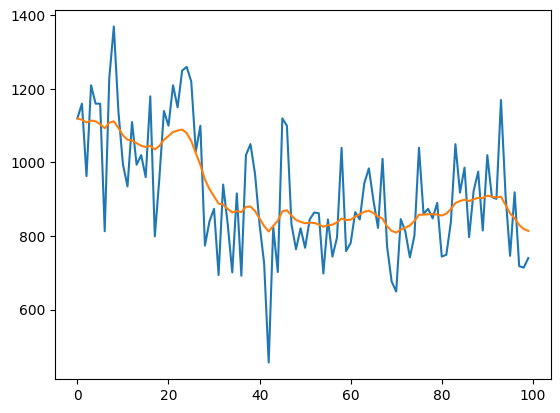

In [79]:
plt.plot(range(100), nile.values)
plt.plot(range(100), posterior_mean_level)

# Regression with Time Varying Coefficients

Similar to the local level, we can do a dynamic regression with time varying coefficients. A simple way to model time varying coefficients is to model the evolution as a random walk:

$$
\begin{aligned}
y_t &= x_t\beta_t + \epsilon_t, & \epsilon_t \sim N(0, \sigma_\epsilon^2)\\ 
\beta_{t+1} &= \beta_t + \xi_t, & \xi_t \sim N(0, \sigma_\xi^2)
\end{aligned}
$$

where $x_t$ is a $1 \times k$ vector of data and $\beta_t$ is a $k \times 1$ vector of coefficients at time $t$.

In [ ]:
def dynamic_regression(y, X):
    T = len(y)

    # State space model parameters
    sigma_level = numpyro.sample("sigma_level", dist.HalfCauchy(1.0))
    sigma_obs = numpyro.sample("sigma_obs", dist.HalfCauchy(1.0))
    # level_0 = numpyro.sample("level_0", dist.Normal(y[0], 1.0))
    # level_0 = y[0]
    beta_0 = numpyro.sample("beta_0", dist.Normal(0,1.0))

    def transition_fn(carry, t):
        beta_t = carry
        # State Transition
        beta_t = numpyro.sample(f"level", dist.Normal(beta_t, sigma_level))
        
        # Observation equation
        mu_t = X @ beta_t
        y_t = numpyro.sample("y", dist.Normal(mu_t, sigma_obs))
        
        return beta_t, None

    N = y.shape[0]
    with numpyro.handlers.condition(data={"y": y}):
        _, ys = scan(
            transition_fn, init=beta_0, xs=jnp.arange(0, N)
        )